In [28]:
import json
import gensim
from matplotlib import pyplot as plt
from gensim.models import Word2Vec,KeyedVectors
from gensim.models.word2vec import LineSentence
from random import shuffle
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.optim as optim
import logging
import time
import pickle

%matplotlib inline
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
embsize = 5

## word2vec

In [30]:
Train_Corpus_path = '../data/Corpus.txt'
Model_path = 'model/w2vModel3.txt'

In [31]:
def A(train_path,model_path):
    #首先打开需要训练的文本
    shuju = open(train_path, 'r')
    #通过Word2vec进行训练
    model = Word2Vec(LineSentence(shuju), sg=1,size=embsize, window=5, min_count=1, workers=15,sample=1e-3)
    #保存训练好的模型
    model.wv.save_word2vec_format(model_path)
    print('训练完成')
    
A(Train_Corpus_path,Model_path)

2021-03-26 16:15:37,532 : WARNING : consider setting layer size to a multiple of 4 for greater performance
2021-03-26 16:15:37,534 : INFO : collecting all words and their counts
2021-03-26 16:15:37,535 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2021-03-26 16:15:37,584 : INFO : PROGRESS: at sentence #10000, processed 51683 words, keeping 8029 word types
2021-03-26 16:15:37,617 : INFO : collected 12094 word types from a corpus of 88871 raw words and 17222 sentences
2021-03-26 16:15:37,625 : INFO : Loading a fresh vocabulary
2021-03-26 16:15:37,647 : INFO : effective_min_count=1 retains 12094 unique words (100% of original 12094, drops 0)
2021-03-26 16:15:37,654 : INFO : effective_min_count=1 leaves 88871 word corpus (100% of original 88871, drops 0)
2021-03-26 16:15:37,710 : INFO : deleting the raw counts dictionary of 12094 items
2021-03-26 16:15:37,711 : INFO : sample=0.001 downsamples 35 most-common words
2021-03-26 16:15:37,712 : INFO : downsampling le

2021-03-26 16:15:43,252 : INFO : worker thread finished; awaiting finish of 5 more threads
2021-03-26 16:15:43,253 : INFO : worker thread finished; awaiting finish of 4 more threads
2021-03-26 16:15:43,255 : INFO : worker thread finished; awaiting finish of 3 more threads
2021-03-26 16:15:43,256 : INFO : worker thread finished; awaiting finish of 2 more threads
2021-03-26 16:15:43,257 : INFO : worker thread finished; awaiting finish of 1 more threads
2021-03-26 16:15:43,265 : INFO : worker thread finished; awaiting finish of 0 more threads
2021-03-26 16:15:43,266 : INFO : EPOCH - 5 : training on 88871 raw words (56056 effective words) took 0.3s, 191984 effective words/s
2021-03-26 16:15:43,267 : INFO : training on a 444355 raw words (280188 effective words) took 1.4s, 197041 effective words/s
2021-03-26 16:15:43,268 : WARNING : under 10 jobs per worker: consider setting a smaller `batch_words' for smoother alpha decay
2021-03-26 16:15:43,268 : INFO : storing 12094x5 projection weights 

训练完成


In [32]:
Mymodel = KeyedVectors.load_word2vec_format(Model_path, binary=False)

print('********************')
print(Mymodel.most_similar(positive=['香港', '经理'], negative=['学生'])  )
#输出[('queen', 0.50882536), ...] 
print('********************')
print(Mymodel.doesnt_match("罗湖区 南山区 法律 龙华区".split())  )
#输出'cereal' 
print('********************')
print(Mymodel.similarity('局长','处长') )
#输出0.73723527
print('********************')
print(Mymodel.most_similar('法律', topn=10) )
print('********************')
print(Mymodel['鄂南'] ) # raw numpy vector of a word  
#输出array([-0.00449447, -0.00310097,  0.02421786, ...], dtype=float32)  

2021-03-26 16:15:44,524 : INFO : loading projection weights from model/w2vModel3.txt
2021-03-26 16:15:44,742 : INFO : loaded (12094, 5) matrix from model/w2vModel3.txt
2021-03-26 16:15:44,745 : INFO : precomputing L2-norms of word weight vectors


********************
[('亚运会', 0.9981467127799988), ('党工委', 0.9979308843612671), ('高级中学', 0.9972034692764282), ('织组', 0.9966740012168884), ('演员', 0.996593713760376), ('信阳', 0.9964818954467773), ('司务长', 0.9952391982078552), ('郴州', 0.9950400590896606), ('淮阴', 0.9949964284896851), ('张家口市', 0.9948666095733643)]
********************
法律
********************
0.944241
********************
[('会计学', 0.9995267987251282), ('新闻学', 0.9990501999855042), ('中南工业大学', 0.9983420372009277), ('大专', 0.9982876777648926), ('及', 0.9978668689727783), ('应用', 0.9978369474411011), ('中国', 0.9971964359283447), ('暨南大学', 0.9968695044517517), ('自动化', 0.9968068599700928), ('国际金融', 0.9966886043548584)]
********************
[-0.05453002  0.21871075  0.09479838 -0.09428279  0.07542817]


## KG

In [2]:
# 打开文件
text_path = '../data/Corpus.txt'
name_path = '../data/powerset.txt'
with open(text_path,'r') as f:
    texts = f.readlines()
f.close()
with open(name_path,'r') as g:
    names = g.readlines()
g.close()
# 统计标签组
label_set = []
for name in names:
    l = eval(name.split('\t',2)[-1])
    label_set.extend(l)
label_set = list(set(label_set))
print(len(label_set))
label2id = {}
for i,label in enumerate(label_set):
    label2id[label] = i
print(label_set)
print(label2id)

34
['双一流大学', '国企事业单位', '盐田', '科技技术', '卫生环保', '福田', '法务纪检', '市人大直属', '市政府直属', '宝安', '深圳1', '一般院校', '深圳', '市委直属', '龙岗', '龙华', '公安', '教育', '大鹏新区', '坪山', '市政协直属', '光明', '党务工作', '深圳市外1', '军检法机构', '理工方向1', '南山', '军检法机构1', '经济金融', '基层工作', '交通运输', '街道基层', '罗湖', '港澳外事']
{'双一流大学': 0, '国企事业单位': 1, '盐田': 2, '科技技术': 3, '卫生环保': 4, '福田': 5, '法务纪检': 6, '市人大直属': 7, '市政府直属': 8, '宝安': 9, '深圳1': 10, '一般院校': 11, '深圳': 12, '市委直属': 13, '龙岗': 14, '龙华': 15, '公安': 16, '教育': 17, '大鹏新区': 18, '坪山': 19, '市政协直属': 20, '光明': 21, '党务工作': 22, '深圳市外1': 23, '军检法机构': 24, '理工方向1': 25, '南山': 26, '军检法机构1': 27, '经济金融': 28, '基层工作': 29, '交通运输': 30, '街道基层': 31, '罗湖': 32, '港澳外事': 33}


#### 构建KG文件

In [26]:
h = open('../data/text2label.txt','w')
for i in range(len(texts)):
    _,flag,labels = names[i].split('\t',2)
    labels = eval(labels)
    for label in labels:
        h.write('{}\ttext.2.label\t{}\n'.format(texts[i].strip(),label))
h.close()

In [28]:
h = open('../data/limit.txt','w')
l2l = [('双一流大学','基层工作'),('龙华','南山'),('港澳外事','龙华'),('军检法机构','双一流大学'),('卫生环保','公安')]
for tu in l2l:
    h.write('{}\tlabel.reject.label\t{}\n'.format(tu[0],tu[1]))
h.close()

#### 训练图谱

In [3]:
word_tensor = {}
Train_Corpus_path = '../data/Corpus.txt'
Model_path = 'model/w2vModel.txt'

In [4]:
# 导入训练练好的Word2Vec模型作初始化
tk0 = time.time()
Mymodel =  KeyedVectors.load_word2vec_format(Model_path, binary=False)
print('Loading W2V Model:',time.time()-tk0,'s')
#print(Mymodel['深圳'] ) # raw numpy vector of a word  

2021-03-26 15:50:33,680 : INFO : loading projection weights from model/w2vModel.txt
2021-03-26 15:50:36,886 : INFO : loaded (12094, 300) matrix from model/w2vModel.txt


Loading W2V Model: 3.207399845123291 s


In [5]:
label_tensor = {}
for key in label_set:
    label_tensor[key] = np.random.rand(embsize)
    label_tensor[key] = torch.Tensor(label_tensor[key])
    label_tensor[key].requires_grad = True

In [6]:
relation_set = ['label.reject.label','text.2.label']
relation_tensor = {}
for key in relation_set:
    relation_tensor[key] = np.random.rand(embsize)
    relation_tensor[key] = torch.Tensor(relation_tensor[key])
    relation_tensor[key].requires_grad = True

In [7]:
word_tensor = {}
for text in texts:
    L = text.strip().split()
    for item in L:
        if item not in word_tensor:
            word_tensor[item] = torch.Tensor(Mymodel[item])
            word_tensor[item].requires_grad = True

<ipython-input-7-1302086e2eaa>:6: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:141.)
  word_tensor[item] = torch.Tensor(Mymodel[item])


In [8]:
# 定义句子的embedding方法
def doc_embd(string):
    res = string.split()
    result = 0
    for item in res:
        if item not in word_tensor:
            word_tensor[item] = Mymodel[item]
            word_tensor[item] = torch.Tensor(word_tensor[item])
            word_tensor[item].requires_grad = True
        result += word_tensor[item]
    doc_embedding = result/len(res)
    return doc_embedding

zw = doc_embd('深圳')
print(type(zw))
#print(zw)

<class 'torch.Tensor'>


In [9]:
allfacts = []
with open('../data/text2label.txt', 'r') as f:
    allfacts.extend(f.readlines())
f.close()
with open('../data/limit.txt', 'r') as f:
    allfacts.extend(f.readlines())
f.close()
print(allfacts[:10])

['深圳 美都美容美发足浴公司 党支部 书记\ttext.2.label\t党务工作\n', '深圳 美都美容美发足浴公司 党支部 书记\ttext.2.label\t深圳\n', '驻 香港 部队 步兵旅 司令部 作训 科长\ttext.2.label\t港澳外事\n', '驻 香港 部队 步兵旅 司令部 作训 科长\ttext.2.label\t军检法机构\n', '驻 香港 部队 步兵旅 司令部 作训 科长\ttext.2.label\t深圳市外1\n', '深圳市人民政府 办公厅 社会 一处 主任科员\ttext.2.label\t深圳\n', '深圳市 节约用水 办公室 主任\ttext.2.label\t深圳\n', '深圳市 综合交通设计研究院有限公司 设计支部委员会 副书记\ttext.2.label\t科技技术\n', '深圳市 综合交通设计研究院有限公司 设计支部委员会 副书记\ttext.2.label\t交通运输\n', '深圳市 综合交通设计研究院有限公司 设计支部委员会 副书记\ttext.2.label\t深圳\n']


In [10]:
# 打分函数
# TransE
def TransE(he,re,te):
    score =  torch.norm(he+re-te)
    return score
fscore = TransE
# **********************************
# Loss函数
def Loss(L):
    loss = 0
    for fact in L:
        h,r,t = fact.strip().split('\t')
        if h not in label_tensor:
            he = doc_embd(h)
        else:
            he = label_tensor[h]
        re = relation_tensor[r]
        if t not in label_tensor:
            te = doc_embd(h)
        else:
            te = label_tensor[t]
        loss += fscore(he,re,te)
    return loss

Before Trainning(First Text): tensor([ 0.1442,  0.0740, -0.0135,  0.3450, -0.3631, -0.0803,  0.2139, -0.0635,
        -0.0517,  0.1062, -0.0944, -0.3770, -0.0591, -0.0565, -0.2256,  0.1626,
        -0.2106, -0.0445, -0.0650, -0.3243,  0.2887, -0.2291, -0.2039,  0.0546,
         0.3436, -0.4006, -0.0976, -0.0695,  0.0367, -0.0282, -0.3366,  0.0137,
         0.1549, -0.2584,  0.0992, -0.2385, -0.1299, -0.0764,  0.3816, -0.0926,
        -0.3583,  0.1229,  0.3504,  0.1395, -0.4602,  0.1754,  0.0375,  0.0601,
         0.1765,  0.0610, -0.5037, -0.3318, -0.0625, -0.1821,  0.1076, -0.2856,
        -0.2178,  0.2934, -0.1109,  0.3356,  0.1511,  0.1882, -0.1756,  0.2165,
        -0.0565,  0.0204,  0.1208, -0.0164, -0.0471, -0.3295, -0.1317,  0.3235,
         0.3362,  0.1298, -0.3241, -0.3857, -0.4878, -0.0022,  0.2762, -0.3839,
         0.2700,  0.2538,  0.0723,  0.1184, -0.6790, -0.1716,  0.1965,  0.1551,
         0.3534,  0.2721,  0.3711,  0.0640, -0.1076, -0.0983,  0.0823,  0.1608,
         0

Epoch 0 - Batch Loss: tensor(582.0579, grad_fn=<AddBackward0>)
Epoch 0 - Batch Loss: tensor(447.8207, grad_fn=<AddBackward0>)
Epoch 0 - Batch Loss: tensor(517.5084, grad_fn=<AddBackward0>)
Epoch 0 - Batch Loss: tensor(541.9288, grad_fn=<AddBackward0>)
Epoch 0 - Batch Loss: tensor(493.6698, grad_fn=<AddBackward0>)
Epoch 0 - Batch Loss: tensor(483.7574, grad_fn=<AddBackward0>)
Epoch 0 - Batch Loss: tensor(561.0714, grad_fn=<AddBackward0>)
Epoch 0 - Batch Loss: tensor(495.1593, grad_fn=<AddBackward0>)
Epoch 0 - Batch Loss: tensor(479.1983, grad_fn=<AddBackward0>)
Epoch 0 - Batch Loss: tensor(479.0616, grad_fn=<AddBackward0>)
Epoch 0 - Batch Loss: tensor(465.5667, grad_fn=<AddBackward0>)
Epoch 0 - Batch Loss: tensor(469.0999, grad_fn=<AddBackward0>)
Epoch 0 - Batch Loss: tensor(490.9201, grad_fn=<AddBackward0>)
Epoch 0 - Batch Loss: tensor(498.7863, grad_fn=<AddBackward0>)
Epoch 0 - Batch Loss: tensor(479.2881, grad_fn=<AddBackward0>)
Epoch 0 - Batch Loss: tensor(466.1159, grad_fn=<AddBack

Epoch 1 - Batch Loss: tensor(380.1288, grad_fn=<AddBackward0>)
Epoch 1 - Batch Loss: tensor(353.2165, grad_fn=<AddBackward0>)
Epoch 1 - Batch Loss: tensor(409.4811, grad_fn=<AddBackward0>)
Epoch 1 - Batch Loss: tensor(425.4282, grad_fn=<AddBackward0>)
Epoch 1 - Batch Loss: tensor(331.5325, grad_fn=<AddBackward0>)
Epoch 1 - Batch Loss: tensor(408.5129, grad_fn=<AddBackward0>)
Epoch 1 - Batch Loss: tensor(345.2845, grad_fn=<AddBackward0>)
Epoch 1 - Batch Loss: tensor(398.1650, grad_fn=<AddBackward0>)
Epoch 1 - Batch Loss: tensor(413.8993, grad_fn=<AddBackward0>)
Epoch 1 - Batch Loss: tensor(405.2167, grad_fn=<AddBackward0>)
Epoch 1 - Batch Loss: tensor(358.1163, grad_fn=<AddBackward0>)
Epoch 1 - Batch Loss: tensor(415.5640, grad_fn=<AddBackward0>)
Epoch 1 - Batch Loss: tensor(379.1413, grad_fn=<AddBackward0>)
Epoch 1 - Batch Loss: tensor(358.9088, grad_fn=<AddBackward0>)
Epoch 1 - Batch Loss: tensor(371.7097, grad_fn=<AddBackward0>)
Epoch 1 - Batch Loss: tensor(361.8510, grad_fn=<AddBack

Epoch 2 - Batch Loss: tensor(336.4154, grad_fn=<AddBackward0>)
Epoch 2 - Batch Loss: tensor(307.9500, grad_fn=<AddBackward0>)
Epoch 2 - Batch Loss: tensor(351.8747, grad_fn=<AddBackward0>)
Epoch 2 - Batch Loss: tensor(325.6076, grad_fn=<AddBackward0>)
Epoch 2 - Batch Loss: tensor(359.4149, grad_fn=<AddBackward0>)
Epoch 2 - Batch Loss: tensor(325.3698, grad_fn=<AddBackward0>)
Epoch 2 - Batch Loss: tensor(364.0806, grad_fn=<AddBackward0>)
Epoch 2 - Batch Loss: tensor(271.0013, grad_fn=<AddBackward0>)
Epoch 2 - Batch Loss: tensor(335.1526, grad_fn=<AddBackward0>)
Epoch 2 - Batch Loss: tensor(287.3306, grad_fn=<AddBackward0>)
Epoch 2 - Batch Loss: tensor(354.4049, grad_fn=<AddBackward0>)
Epoch 2 - Batch Loss: tensor(305.4586, grad_fn=<AddBackward0>)
Epoch 2 - Batch Loss: tensor(321.3224, grad_fn=<AddBackward0>)
Epoch 2 - Batch Loss: tensor(345.1018, grad_fn=<AddBackward0>)
Epoch 2 - Batch Loss: tensor(282.8402, grad_fn=<AddBackward0>)
Epoch 2 - Batch Loss: tensor(380.1490, grad_fn=<AddBack

Epoch 3 - Batch Loss: tensor(292.4933, grad_fn=<AddBackward0>)
Epoch 3 - Batch Loss: tensor(262.9567, grad_fn=<AddBackward0>)
Epoch 3 - Batch Loss: tensor(309.8568, grad_fn=<AddBackward0>)
Epoch 3 - Batch Loss: tensor(323.4774, grad_fn=<AddBackward0>)
Epoch 3 - Batch Loss: tensor(339.7137, grad_fn=<AddBackward0>)
Epoch 3 - Batch Loss: tensor(311.6755, grad_fn=<AddBackward0>)
Epoch 3 - Batch Loss: tensor(318.4315, grad_fn=<AddBackward0>)
Epoch 3 - Batch Loss: tensor(266.7117, grad_fn=<AddBackward0>)
Epoch 3 - Batch Loss: tensor(355.2930, grad_fn=<AddBackward0>)
Epoch 3 - Batch Loss: tensor(337.1050, grad_fn=<AddBackward0>)
Epoch 3 - Batch Loss: tensor(299.9900, grad_fn=<AddBackward0>)
Epoch 3 - Batch Loss: tensor(295.0881, grad_fn=<AddBackward0>)
Epoch 3 - Batch Loss: tensor(368.1911, grad_fn=<AddBackward0>)
Epoch 3 - Batch Loss: tensor(318.9061, grad_fn=<AddBackward0>)
Epoch 3 - Batch Loss: tensor(278.9019, grad_fn=<AddBackward0>)
Epoch 3 - Batch Loss: tensor(318.7212, grad_fn=<AddBack

Epoch 4 - Batch Loss: tensor(273.2926, grad_fn=<AddBackward0>)
Epoch 4 - Batch Loss: tensor(314.4807, grad_fn=<AddBackward0>)
Epoch 4 - Batch Loss: tensor(326.3551, grad_fn=<AddBackward0>)
Epoch 4 - Batch Loss: tensor(299.5879, grad_fn=<AddBackward0>)
Epoch 4 - Batch Loss: tensor(298.8407, grad_fn=<AddBackward0>)
Epoch 4 - Batch Loss: tensor(287.1249, grad_fn=<AddBackward0>)
Epoch 4 - Batch Loss: tensor(269.4343, grad_fn=<AddBackward0>)
Epoch 4 - Batch Loss: tensor(296.0606, grad_fn=<AddBackward0>)
Epoch 4 - Batch Loss: tensor(322.7487, grad_fn=<AddBackward0>)
Epoch 4 - Batch Loss: tensor(320.2121, grad_fn=<AddBackward0>)
Epoch 4 - Batch Loss: tensor(282.1381, grad_fn=<AddBackward0>)
Epoch 4 - Batch Loss: tensor(302.6798, grad_fn=<AddBackward0>)
Epoch 4 - Batch Loss: tensor(300.3644, grad_fn=<AddBackward0>)
Epoch 4 - Batch Loss: tensor(296.9041, grad_fn=<AddBackward0>)
Epoch 4 - Batch Loss: tensor(293.6923, grad_fn=<AddBackward0>)
Epoch 4 - Batch Loss: tensor(319.5908, grad_fn=<AddBack

Epoch 5 - Batch Loss: tensor(275.8197, grad_fn=<AddBackward0>)
Epoch 5 - Batch Loss: tensor(265.3690, grad_fn=<AddBackward0>)
Epoch 5 - Batch Loss: tensor(324.5884, grad_fn=<AddBackward0>)
Epoch 5 - Batch Loss: tensor(264.5491, grad_fn=<AddBackward0>)
Epoch 5 - Batch Loss: tensor(304.4467, grad_fn=<AddBackward0>)
Epoch 5 - Batch Loss: tensor(313.2188, grad_fn=<AddBackward0>)
Epoch 5 - Batch Loss: tensor(367.8850, grad_fn=<AddBackward0>)
Epoch 5 - Batch Loss: tensor(304.5409, grad_fn=<AddBackward0>)
Epoch 5 - Batch Loss: tensor(322.9845, grad_fn=<AddBackward0>)
Epoch 5 - Batch Loss: tensor(298.4960, grad_fn=<AddBackward0>)
Epoch 5 - Batch Loss: tensor(327.7582, grad_fn=<AddBackward0>)
Epoch 5 - Batch Loss: tensor(300.5813, grad_fn=<AddBackward0>)
Epoch 5 - Batch Loss: tensor(287.0525, grad_fn=<AddBackward0>)
Epoch 5 - Batch Loss: tensor(285.5741, grad_fn=<AddBackward0>)
Epoch 5 - Batch Loss: tensor(285.6776, grad_fn=<AddBackward0>)
Epoch 5 - Batch Loss: tensor(313.9114, grad_fn=<AddBack

Epoch 6 - Batch Loss: tensor(320.1781, grad_fn=<AddBackward0>)
Epoch 6 - Batch Loss: tensor(295.6985, grad_fn=<AddBackward0>)
Epoch 6 - Batch Loss: tensor(276.6879, grad_fn=<AddBackward0>)
Epoch 6 - Batch Loss: tensor(259.2893, grad_fn=<AddBackward0>)
Epoch 6 - Batch Loss: tensor(322.4726, grad_fn=<AddBackward0>)
Epoch 6 - Batch Loss: tensor(261.8762, grad_fn=<AddBackward0>)
Epoch 6 - Batch Loss: tensor(291.0500, grad_fn=<AddBackward0>)
Epoch 6 - Batch Loss: tensor(262.1798, grad_fn=<AddBackward0>)
Epoch 6 - Batch Loss: tensor(335.5339, grad_fn=<AddBackward0>)
Epoch 6 - Batch Loss: tensor(302.7899, grad_fn=<AddBackward0>)
Epoch 6 - Batch Loss: tensor(266.9153, grad_fn=<AddBackward0>)
Epoch 6 - Batch Loss: tensor(293.7153, grad_fn=<AddBackward0>)
Epoch 6 - Batch Loss: tensor(336.5323, grad_fn=<AddBackward0>)
Epoch 6 - Batch Loss: tensor(312.5788, grad_fn=<AddBackward0>)
Epoch 6 - Batch Loss: tensor(341.5430, grad_fn=<AddBackward0>)
Epoch 6 - Batch Loss: tensor(276.4040, grad_fn=<AddBack

Epoch 7 - Batch Loss: tensor(343.4206, grad_fn=<AddBackward0>)
Epoch 7 - Batch Loss: tensor(256.0244, grad_fn=<AddBackward0>)
Epoch 7 - Batch Loss: tensor(295.6460, grad_fn=<AddBackward0>)
Epoch 7 - Batch Loss: tensor(292.9371, grad_fn=<AddBackward0>)
Epoch 7 - Batch Loss: tensor(255.1159, grad_fn=<AddBackward0>)
Epoch 7 - Batch Loss: tensor(335.8193, grad_fn=<AddBackward0>)
Epoch 7 - Batch Loss: tensor(296.2448, grad_fn=<AddBackward0>)
Epoch 7 - Batch Loss: tensor(302.3138, grad_fn=<AddBackward0>)
Epoch 7 - Batch Loss: tensor(306.9272, grad_fn=<AddBackward0>)
Epoch 7 - Batch Loss: tensor(285.4006, grad_fn=<AddBackward0>)
Epoch 7 - Batch Loss: tensor(308.4241, grad_fn=<AddBackward0>)
Epoch 7 - Batch Loss: tensor(295.9642, grad_fn=<AddBackward0>)
Epoch 7 - Batch Loss: tensor(296.9765, grad_fn=<AddBackward0>)
Epoch 7 - Batch Loss: tensor(308.5751, grad_fn=<AddBackward0>)
Epoch 7 - Batch Loss: tensor(276.1827, grad_fn=<AddBackward0>)
Epoch 7 - Batch Loss: tensor(285.6741, grad_fn=<AddBack

Epoch 8 - Batch Loss: tensor(317.2844, grad_fn=<AddBackward0>)
Epoch 8 - Batch Loss: tensor(273.1647, grad_fn=<AddBackward0>)
Epoch 8 - Batch Loss: tensor(307.0386, grad_fn=<AddBackward0>)
Epoch 8 - Batch Loss: tensor(268.4367, grad_fn=<AddBackward0>)
Epoch 8 - Batch Loss: tensor(256.0028, grad_fn=<AddBackward0>)
Epoch 8 - Batch Loss: tensor(294.3674, grad_fn=<AddBackward0>)
Epoch 8 - Batch Loss: tensor(316.2577, grad_fn=<AddBackward0>)
Epoch 8 - Batch Loss: tensor(276.6487, grad_fn=<AddBackward0>)
Epoch 8 - Batch Loss: tensor(351.4377, grad_fn=<AddBackward0>)
Epoch 8 - Batch Loss: tensor(245.3644, grad_fn=<AddBackward0>)
Epoch 8 - Batch Loss: tensor(317.2142, grad_fn=<AddBackward0>)
Epoch 8 - Batch Loss: tensor(253.9274, grad_fn=<AddBackward0>)
Epoch 8 - Batch Loss: tensor(293.8730, grad_fn=<AddBackward0>)
Epoch 8 - Batch Loss: tensor(289.8570, grad_fn=<AddBackward0>)
Epoch 8 - Batch Loss: tensor(316.7290, grad_fn=<AddBackward0>)
Epoch 8 - Batch Loss: tensor(290.7073, grad_fn=<AddBack

Epoch 9 - Batch Loss: tensor(256.5023, grad_fn=<AddBackward0>)
Epoch 9 - Batch Loss: tensor(262.7022, grad_fn=<AddBackward0>)
Epoch 9 - Batch Loss: tensor(318.0620, grad_fn=<AddBackward0>)
Epoch 9 - Batch Loss: tensor(285.1078, grad_fn=<AddBackward0>)
Epoch 9 - Batch Loss: tensor(260.4895, grad_fn=<AddBackward0>)
Epoch 9 - Batch Loss: tensor(320.1684, grad_fn=<AddBackward0>)
Epoch 9 - Batch Loss: tensor(240.4922, grad_fn=<AddBackward0>)
Epoch 9 - Batch Loss: tensor(284.2398, grad_fn=<AddBackward0>)
Epoch 9 - Batch Loss: tensor(275.8812, grad_fn=<AddBackward0>)
Epoch 9 - Batch Loss: tensor(274.2721, grad_fn=<AddBackward0>)
Epoch 9 - Batch Loss: tensor(309.2077, grad_fn=<AddBackward0>)
Epoch 9 - Batch Loss: tensor(315.1269, grad_fn=<AddBackward0>)
Epoch 9 - Batch Loss: tensor(271.4916, grad_fn=<AddBackward0>)
Epoch 9 - Batch Loss: tensor(337.6102, grad_fn=<AddBackward0>)
Epoch 9 - Batch Loss: tensor(280.0358, grad_fn=<AddBackward0>)
Epoch 9 - Batch Loss: tensor(301.0800, grad_fn=<AddBack

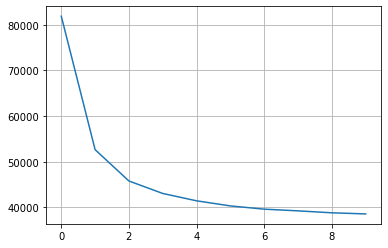

In [11]:
LossList = []
parameter = {**label_tensor,**word_tensor,**relation_tensor}.values()
optimizer = optim.SGD(parameter,lr=0.005)
batch_size = 512
print('Before Trainning(First Text):',word_tensor['深圳'])

for epoch in range(10):
    epoch_loss = 0
    shuffle(allfacts)
    list2 = []
    for i in range(0, len(allfacts), batch_size):
        list2.append(allfacts[i:i+batch_size])
    for sub_batch in list2:
        optimizer.zero_grad()
        liu = Loss(sub_batch)
        # print(type(liu))
        print('Epoch',epoch,'- Batch Loss:',liu)
        epoch_loss += float(liu)
        liu.backward(retain_graph=True)
        optimizer.step()
    print('Epoch',epoch,'finished. Loss:',epoch_loss)
    LossList.append(epoch_loss)
    
print('After Trainning(First Text):',word_tensor['深圳'])
plt.grid(True)
plt.plot(range(len(LossList)),LossList)

In [15]:
final = {**label_tensor,**word_tensor,**relation_tensor}
f = open('model/kge1.kge','wb')
pickle.dump(final,f)
f.close()

In [18]:
f = open('model/kge1.kge','rb')
liu = pickle.load(f)
f.close()
liu['深圳']

tensor([-0.2257, -0.2069, -0.1890,  0.0949, -0.0418,  0.1746, -0.0699,  0.1981,
         0.0105, -0.0788, -0.2114, -0.1839,  0.1660, -0.2282, -0.3175, -0.2853,
        -0.2831, -0.0184, -0.0931, -0.2646,  0.2686, -0.4916, -0.2039,  0.2962,
         0.1197, -0.4686,  0.0143, -0.0496,  0.2560, -0.3231, -0.3294, -0.0338,
         0.2137,  0.0952, -0.0669, -0.0238,  0.1799, -0.2170,  0.2854,  0.0182,
        -0.0955,  0.1069,  0.2421, -0.0130, -0.3776, -0.0621,  0.0351,  0.2888,
        -0.0451,  0.3833,  0.1113,  0.1978, -0.0224,  0.0429, -0.1056, -0.0648,
        -0.3080,  0.0636, -0.1800,  0.3061,  0.0986, -0.1727, -0.5064,  0.4789,
         0.0640, -0.0519, -0.0743, -0.0853, -0.1325, -0.0241, -0.5257,  0.1210,
        -0.3653,  0.0516,  0.0405, -0.0916, -0.4372,  0.2872, -0.3748, -0.2332,
         0.2002,  0.1791,  0.1591, -0.1416,  0.1241,  0.1186,  0.4286,  0.2661,
         0.2387, -0.0742,  0.0618,  0.1640, -0.1391, -0.0396,  0.4437,  0.3330,
        -0.0458,  0.2237,  0.0898, -0.22

In [ ]:
a = {'q':1,'w':2,'e':3}
b = {'w':1.5,'s':2.5}
c = {**b,**a}
c